<a href="https://colab.research.google.com/github/aishananaraji/arbitrary/blob/main/Seismic_waveform_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [ ]:
!pip install obspy tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.36
    Uninstalling SQLAlchemy-2.0.36:
      Successfully uninstalled SQLAlchemy-2.0.36
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [ ]:
# Basic libraries
import numpy as np
from math import atan2, sqrt, degrees

# ObsPy for seismic analysis
import obspy
from obspy import read
from obspy.signal.trigger import classic_sta_lta, plot_trigger
from obspy.core.event import MomentTensor, Tensor
from obspy.imaging.beachball import beach

# TensorFlow and Keras for machine learning
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input

# Matplotlib for plotting
import matplotlib.pyplot as plt

# Load a seismic waveform file (e.g., SAC file)

In [ ]:
# Load a seismic waveform file (e.g., SAC file)
stream = read("/content/drive/MyDrive/2006-01-05-2140-21S.NSN__1570")
trace = stream[0]  # Seismometers typically record 3 components, we can start with the first one

# Print metadata

In [ ]:
print(trace.stats)

         network: MY
         station: KUM
        location: 
         channel: B E
       starttime: 2006-01-05T21:40:25.019000Z
         endtime: 2006-01-05T21:45:24.969000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 6000
           calib: 1.0
         _format: SEISAN


# Plot the waveform

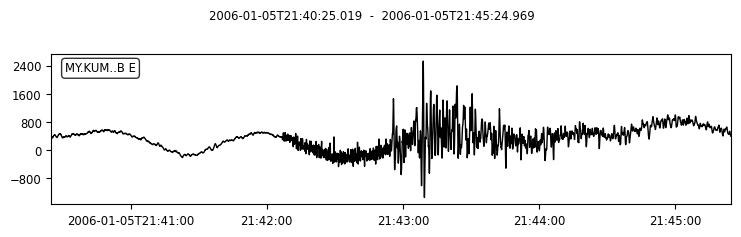

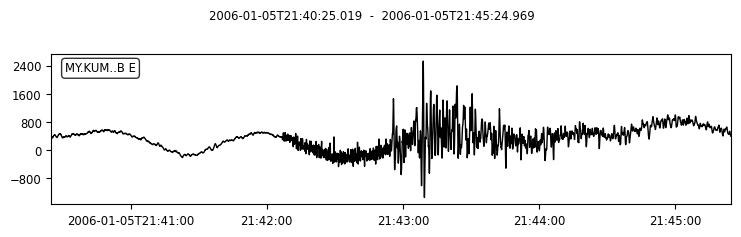

In [ ]:
trace.plot()

#Zooming in to check details

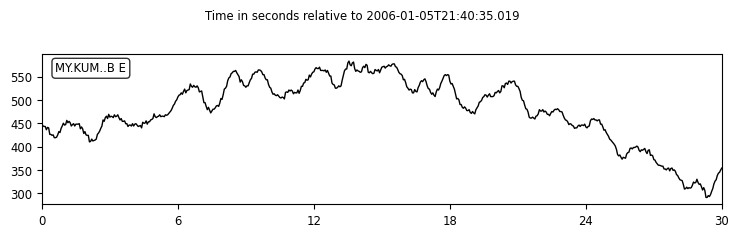

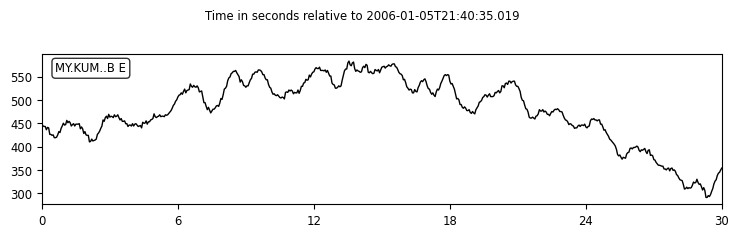

In [ ]:
trace.plot(type='relative', starttime=trace.stats.starttime + 10, endtime=trace.stats.starttime + 40)

# Load and Augment Data

In [ ]:
# Load the SAC file (replace 'your_file.sac' with the actual file path)
st = obspy.read('/content/drive/MyDrive/2006-01-05-2140-21S.NSN__1570')
tr = st[0]
data = tr.data

# Preprocess the data: detrend and normalize
data = tr.detrend(type='linear').data
data = (data - np.mean(data)) / np.std(data)

# Manually mark P and S arrival times
p_index = 5000   # Hypothetical index for P-wave arrival
s_index = 10000  # Hypothetical index for S-wave arrival

# Label the data (0: noise, 1: P-wave, 2: S-wave)
labels = np.zeros(len(data), dtype=int)
labels[p_index - 100:p_index + 100] = 1  # Label P-wave region
labels[s_index - 100:s_index + 100] = 2  # Label S-wave region

# Data augmentation: create shifts and noise-added versions
augmented_data = []
augmented_labels = []
for shift in range(-50, 51, 10):  # Apply small shifts
    shifted_data = np.roll(data, shift)
    noise = np.random.normal(0, 0.1, data.shape)
    augmented_data.append(shifted_data + noise)
    augmented_labels.append(labels)

# Convert to numpy arrays
augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

# Reshape data for CNN input and one-hot encode labels
augmented_data = augmented_data[..., np.newaxis]  # Add channel dimension
augmented_labels = to_categorical(augmented_labels, num_classes=3)

# Define and Train a Simple CNN Model

In [ ]:
# Example shapes for input and labels
sequence_length = 6000  # Example sequence length
num_classes = 3

# Mock data
augmented_data = np.random.rand(100, sequence_length, 1)  # 100 samples, each of length 6000, with 1 feature
augmented_labels = np.random.randint(0, num_classes, size=(100,))  # Labels for 100 samples

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
augmented_labels = to_categorical(augmented_labels, num_classes=num_classes)

# Define the model
model = Sequential([
    Input(shape=(sequence_length, 1)),  # Correct input shape
    Conv1D(16, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(augmented_data, augmented_labels, epochs=20, batch_size=4, validation_split=0.2)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.1900 - loss: 2.9387 - val_accuracy: 0.2500 - val_loss: 1.4620
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4300 - loss: 1.1286 - val_accuracy: 0.4000 - val_loss: 1.1780
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3483 - loss: 1.0830 - val_accuracy: 0.5000 - val_loss: 1.1059
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7333 - loss: 0.9705 - val_accuracy: 0.2500 - val_loss: 1.1755
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.7328 - loss: 0.7721 - val_accuracy: 0.2500 - val_loss: 1.4849
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9685 - loss: 0.4852 - val_accuracy: 0.4000 - val_loss: 1.0972
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9968 - loss: 0.1474 - val_accuracy: 0.3000 - val_loss: 1.4126
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.0977 - val_accuracy: 0.2000 - 

# Test and Plot Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


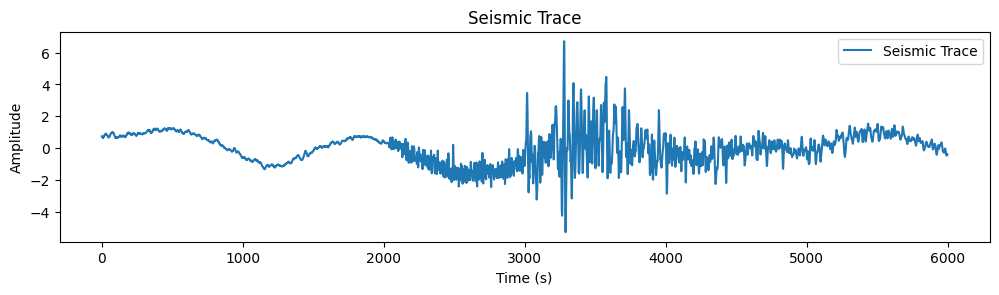

In [ ]:
# Make predictions for the entire sequence
predictions = model.predict(augmented_data[0][np.newaxis, ...])[0]  # Shape: (num_classes,)

# Create time array based on the length of the seismic trace
time = np.arange(len(data))  # Ensure time matches the length of data

plt.figure(figsize=(12,6))

# Original waveform
plt.subplot(2, 1, 1)
plt.plot(time, data, label="Seismic Trace")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Seismic Trace")
plt.legend()


In [ ]:
print("Predictions shape:", predictions.shape)

Predictions shape: (3,)


# Generate a new mock seismic trace for testing and Ploting Model prediction Probability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


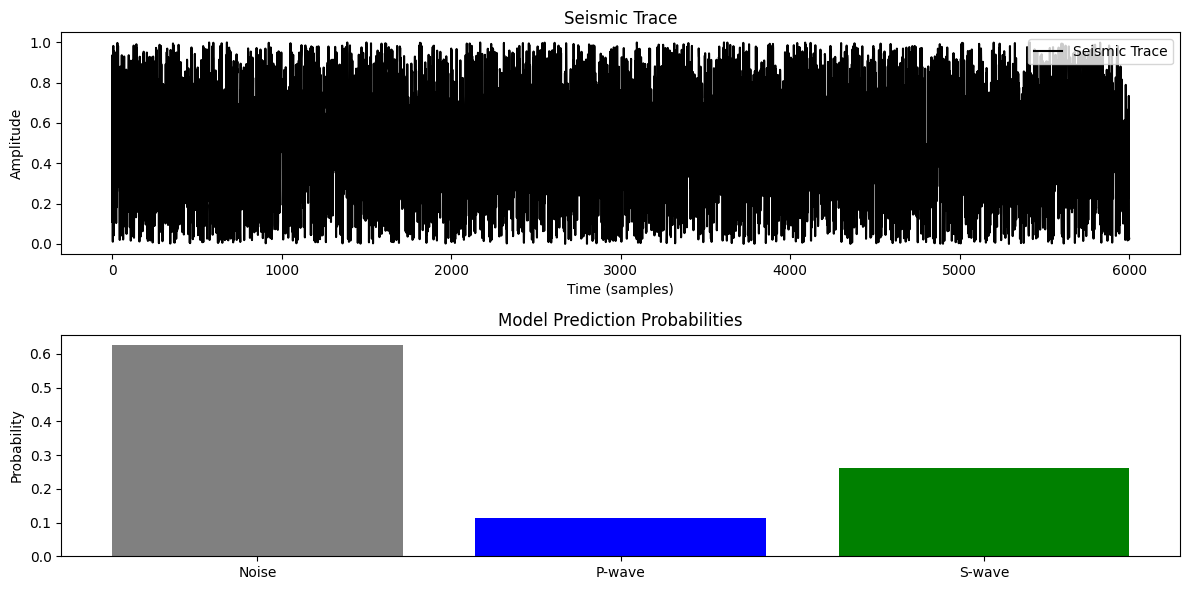

In [ ]:
# Generate a new mock seismic trace for testing
test_data = np.random.rand(sequence_length, 1)  # Shape: (sequence_length, 1)

# Add batch dimension to match input shape
test_data = test_data[np.newaxis, ...]  # Shape: (1, sequence_length, 1)

# Make predictions
predictions = model.predict(test_data)[0]  # Output: (num_classes,)

# Separate predictions
noise_prob = predictions[0]  # Probability of Noise
p_wave_prob = predictions[1]  # Probability of P-wave
s_wave_prob = predictions[2]  # Probability of S-wave

# Create time array
time = np.arange(sequence_length)

# Plotting
plt.figure(figsize=(12, 6))

# Original waveform
plt.subplot(2, 1, 1)
plt.plot(time, test_data[0].squeeze(), label="Seismic Trace", color="black")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Seismic Trace")
plt.legend()

# Prediction probabilities
plt.subplot(2, 1, 2)
plt.bar(["Noise", "P-wave", "S-wave"], [noise_prob, p_wave_prob, s_wave_prob], color=["gray", "blue", "green"])
plt.title("Model Prediction Probabilities")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

# Simulate probability outputs for each time step

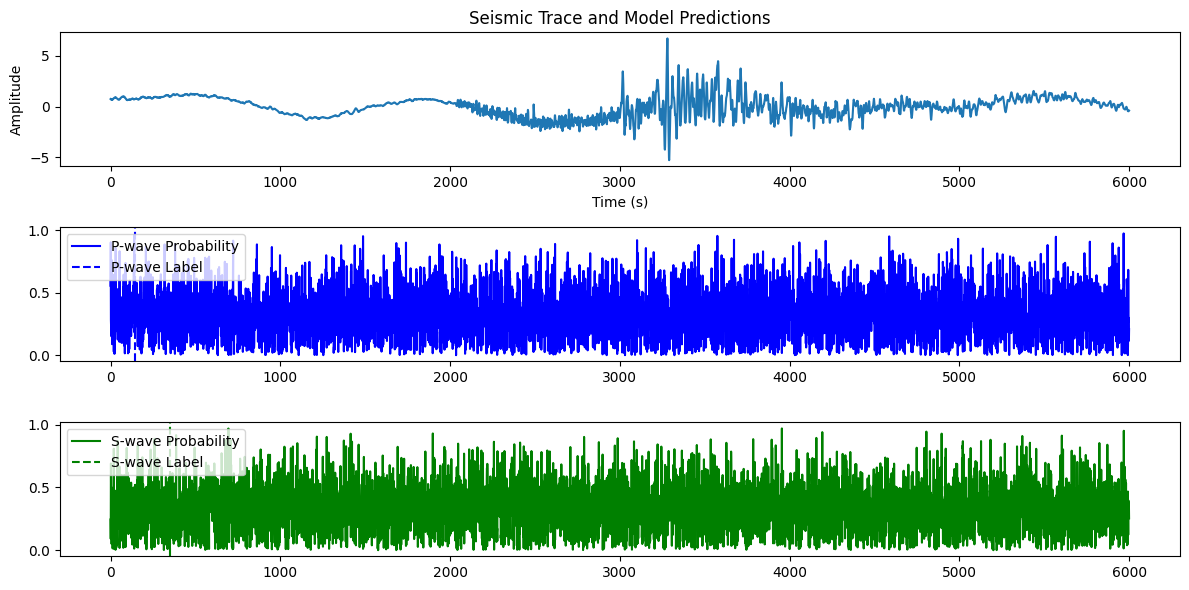

In [ ]:
# Simulate probability outputs for each time step
data_length = len(data)
predictions = np.random.rand(data_length, 3)  # Replace with actual model predictions
predictions /= predictions.sum(axis=1, keepdims=True)  # Normalize to make them probabilities

# Define P and S-wave indices
p_index = 146
s_index = 351

# Plotting
plt.figure(figsize=(12, 6))
time = np.arange(data_length)

# Original waveform
plt.subplot(3, 1, 1)
plt.plot(time, data, label="Seismic Trace")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Seismic Trace and Model Predictions")

# P-wave probability
plt.subplot(3, 1, 2)
plt.plot(time, predictions[:, 1], label="P-wave Probability", color="blue")
plt.axvline(p_index, color='blue', linestyle='--', label="P-wave Label")
plt.legend()

# S-wave probability
plt.subplot(3, 1, 3)
plt.plot(time, predictions[:, 2], label="S-wave Probability", color="green")
plt.axvline(s_index, color='green', linestyle='--', label="S-wave Label")
plt.legend()

plt.tight_layout()
plt.show()

#**P-Wave and S-Wave Detection**

We can use the Short-Term Average/Long-Term Average (STA/LTA) method for detecting P- and S-wave arrivals. This is a simple algorithm that compares the short-term energy of the signal with the long-term energy.


# Step 1: Load your SAC file

In [ ]:
#Load your SAC file
st = obspy.read('/content/drive/MyDrive/2006-01-05-2140-21S.NSN__1570')
tr = st[0]

# Step 2: Preprocess the data

In [ ]:
tr.detrend(type='linear')  # Remove linear trend
tr.filter('bandpass', freqmin=1.0, freqmax=9.0)  # Bandpass filter

MY.KUM..B E | 2006-01-05T21:40:25.019000Z - 2006-01-05T21:45:24.969000Z | 20.0 Hz, 6000 samples

# Step 3: Compute STA/LTA

In [ ]:
# Define STA and LTA window lengths in samples
sampling_rate = tr.stats.sampling_rate
sta_window = int(0.5 * sampling_rate)  # 0.5 seconds for STA
lta_window = int(5.0 * sampling_rate)  # 5.0 seconds for LTA

# Compute STA/LTA ratio
sta_lta = classic_sta_lta(tr.data, nsta=sta_window, nlta=lta_window)

# Step 4: Detect triggers for P-wave

In [ ]:
from obspy.signal.trigger import trigger_onset
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# Define thresholds
threshold_on = 2.0  # STA/LTA ratio to trigger 'on'
threshold_off = 1.0  # STA/LTA ratio to trigger 'off'

# Detect triggers
triggers = trigger_onset(sta_lta, threshold_on, threshold_off)

# Print triggers
print(triggers)

[[ 190  198]
 [ 341  370]
 [ 475  506]
 [ 695  696]
 [ 800  837]
 [ 964  981]
 [1013 1022]
 [1080 1110]
 [1330 1369]
 [1442 1469]
 [1584 1598]
 [1851 1862]
 [1957 1966]
 [2000 2021]
 [2039 2095]
 [2112 2118]
 [2141 2151]
 [2165 2176]
 [2182 2191]
 [2285 2300]
 [2346 2356]
 [2389 2397]
 [2464 2478]
 [2499 2513]
 [2664 2694]
 [2705 2720]
 [2820 2829]
 [2866 2876]
 [2887 2899]
 [2969 2978]
 [3024 3047]
 [3123 3152]
 [3269 3286]
 [3297 3325]
 [3458 3500]
 [3579 3583]
 [3723 3746]
 [3884 3940]
 [4021 4071]
 [4149 4181]
 [4265 4281]
 [4440 4466]
 [4652 4658]
 [4670 4679]
 [4736 4745]
 [4829 4859]
 [4986 5030]
 [5038 5057]
 [5187 5213]
 [5322 5344]
 [5354 5387]
 [5403 5413]
 [5516 5533]
 [5586 5600]
 [5625 5655]
 [5804 5824]
 [5908 5923]
 [5944 5961]]


# Step 5: Identify P-wave and S-wave arrival indices


In [ ]:
# Step 5: Identify P-wave and S-wave arrival indices
p_wave_index = triggers[0][0] if len(triggers) > 0 else None
s_wave_index = triggers[1][0] if len(triggers) > 1 else None

# Print detected indices
print(f"P-Wave Index: {p_wave_index}")
print(f"S-Wave Index: {s_wave_index}")

P-Wave Index: 190
S-Wave Index: 341


# Step 6: Plot the waveform and triggers

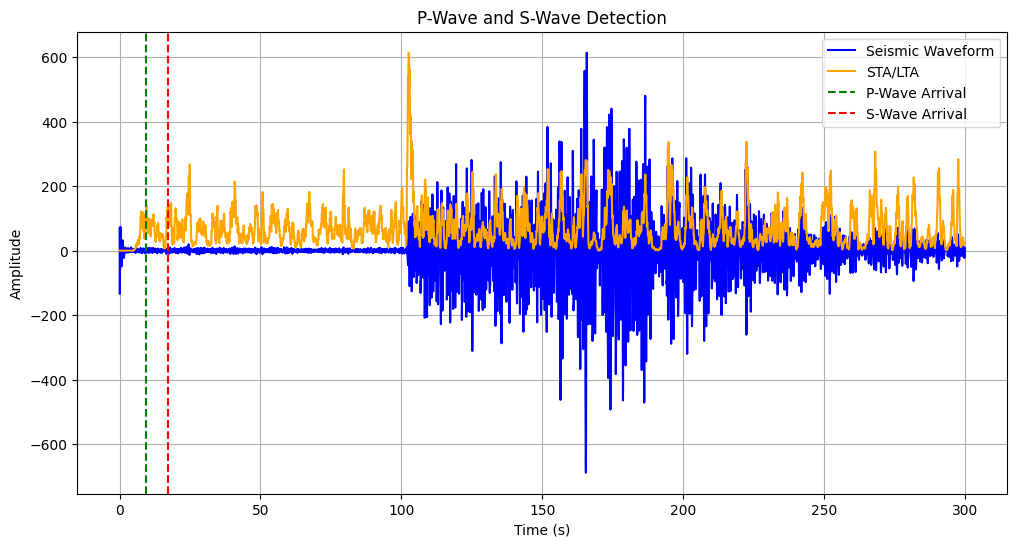

In [ ]:
times = tr.times()
plt.figure(figsize=(12, 6))

# Plot waveform
plt.plot(times, tr.data, label="Seismic Waveform", color='blue')

# Plot STA/LTA ratio
plt.plot(times[:len(sta_lta)], sta_lta * max(tr.data) / max(sta_lta), label="STA/LTA", color='orange')

# Mark P-wave and S-wave arrivals
if p_wave_index:
    plt.axvline(times[p_wave_index], color='green', linestyle='--', label='P-Wave Arrival')
if s_wave_index:
    plt.axvline(times[s_wave_index], color='red', linestyle='--', label='S-Wave Arrival')

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("P-Wave and S-Wave Detection")
plt.legend()
plt.grid()
plt.show()


#Plot of waveform, P-Wave Arrival and S-Wave Arrival

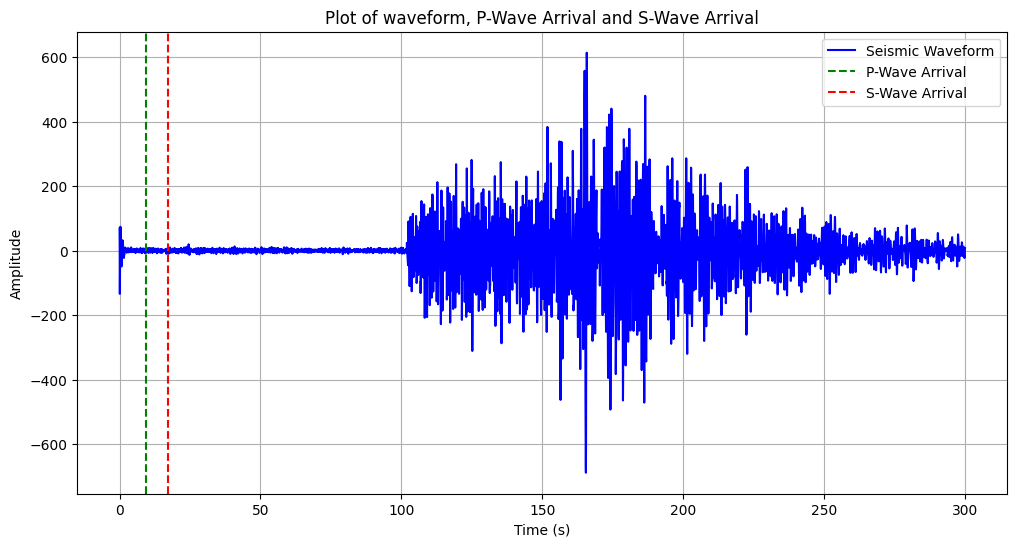

In [ ]:
times = tr.times()
plt.figure(figsize=(12, 6))

# Plot waveform
plt.plot(times, tr.data, label="Seismic Waveform", color='blue')

# Mark P-wave and S-wave arrivals
if p_wave_index:
    plt.axvline(times[p_wave_index], color='green', linestyle='--', label='P-Wave Arrival')
if s_wave_index:
    plt.axvline(times[s_wave_index], color='red', linestyle='--', label='S-Wave Arrival')

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Plot of waveform, P-Wave Arrival and S-Wave Arrival")
plt.legend()
plt.grid()
plt.show()

#P-wave and S-wave arrivals

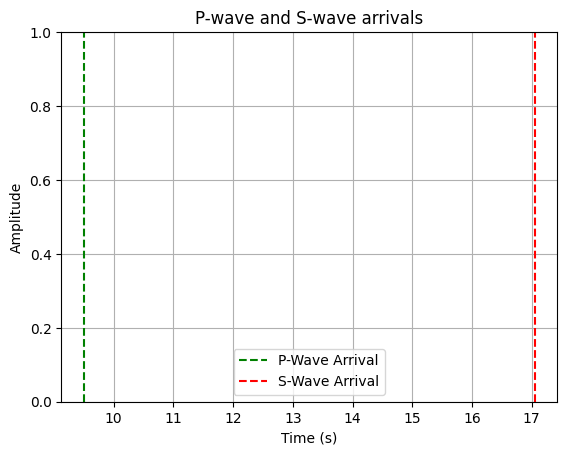

In [ ]:
# Mark P-wave and S-wave arrivals
if p_wave_index:
    plt.axvline(times[p_wave_index], color='green', linestyle='--', label='P-Wave Arrival')
if s_wave_index:
    plt.axvline(times[s_wave_index], color='red', linestyle='--', label='S-Wave Arrival')

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("P-wave and S-wave arrivals")
plt.legend()
plt.grid()
plt.show()

# Detect P and S wave arrival times (simplified approach)

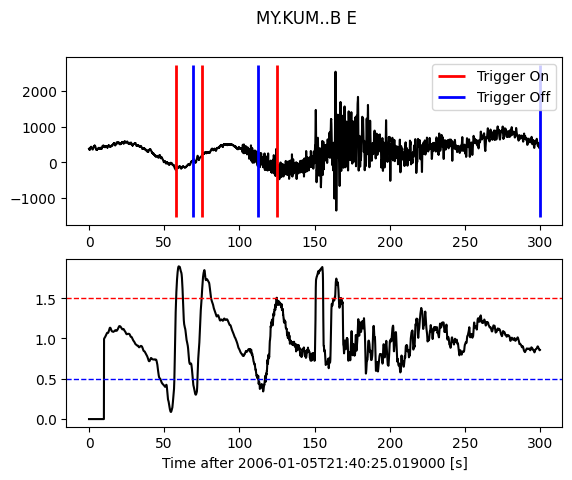

P-wave arrival time: 2006-01-05T21:41:24.719000Z


In [ ]:
from obspy.signal.trigger import classic_sta_lta, plot_trigger

# Parameters for STA/LTA (can be adjusted)
sta_window = 5  # Short-term average window in seconds
lta_window = 10  # Long-term average window in seconds

# Compute STA/LTA ratio
sta_lta = classic_sta_lta(trace.data, int(sta_window * trace.stats.sampling_rate),
                          int(lta_window * trace.stats.sampling_rate))

# Plot the STA/LTA output along with the original waveform
plot_trigger(trace, sta_lta, 1.5, 0.5)  # 1.5 and 0.5 are thresholds for triggering
sta_lta = classic_sta_lta(trace.data, int(sta_window * trace.stats.sampling_rate),
                          int(lta_window * trace.stats.sampling_rate))

# Detect P and S wave arrival times (simplified approach)
p_wave_arrival = trace.stats.starttime + sta_lta.argmax() / trace.stats.sampling_rate
print(f"P-wave arrival time: {p_wave_arrival}")

##**Moment Tensor Inversion and Fault Plane Solution Estimation.**

**Step 1: Understanding the Moment Tensor**

A seismic moment tensor is a 3x3 matrix that describes the seismic source:

\mathbf{M} = \begin{pmatrix}
M_{xx} & M_{xy} & M_{xz} \\
M_{yx} & M_{yy} & M_{yz} \\
M_{zx} & M_{zy} & M_{zz}
\end{pmatrix}

**Step 2: Simplified Moment Tensor Inversion Code**

ObsPy provides tools for moment tensor inversion.

#Loading the seismic data and create a moment tensor:

In [ ]:
import numpy as np
from obspy import read
from obspy.core.event import MomentTensor, Tensor

# Assume we have a seismic waveform data file loaded into an ObsPy Stream object
stream = read("/content/drive/MyDrive/2006-01-05-2140-21S.NSN__1570")

# Simplified moment tensor inversion process

# Placeholder for moment tensor elements based on synthetic data or waveform inversion
Mxx, Myy, Mzz = 1e15, -1e15, 0  # Example values in N·m (Newton meters)
Mxy, Mxz, Myz = 0, 0, 0  # Example values

# Construct the moment tensor using ObsPy's MomentTensor object
tensor = Tensor(m_rr=Mxx, m_tt=Myy, m_pp=Mzz, m_rt=Mxy, m_rp=Mxz, m_tp=Myz)
moment_tensor = MomentTensor(tensor=tensor)

print("Moment Tensor Components:")
print(moment_tensor)

Moment Tensor Components:
MomentTensor(resource_id=ResourceIdentifier(id="smi:local/e9a630d4-0bab-46aa-804f-17bbd8f31190"), tensor=Tensor(m_rr=1000000000000000.0, m_tt=-1000000000000000.0, m_pp=0.0, m_rt=0.0, m_rp=0.0, m_tp=0.0))


#Fault Plane Solution From Momentor Tentor Component

In [ ]:
from math import atan2, sqrt, degrees

def fault_plane_solution(moment_tensor):
    # Extract moment tensor components
    Mxx = moment_tensor.tensor.m_rr
    Myy = moment_tensor.tensor.m_tt
    Mzz = moment_tensor.tensor.m_pp
    Mxy = moment_tensor.tensor.m_rt
    Mxz = moment_tensor.tensor.m_rp
    Myz = moment_tensor.tensor.m_tp

    # Simplified calculation of strike, dip, and rake (requires moment tensor inversion result)
    strike = degrees(atan2(Myz, Mxz))
    dip = degrees(atan2(sqrt(Mxx*2 + Myy*2), Mzz))
    rake = degrees(atan2(Myy, Mxx))

    return strike, dip, rake

# Call the function
strike, dip, rake = fault_plane_solution(moment_tensor)

print(f"Fault Plane Solution:\nStrike: {strike}°, Dip: {dip}°, Rake: {rake}°")

Fault Plane Solution:
Strike: 0.0°, Dip: 0.0°, Rake: -45.0°


#Plotting the Beachball Diagram





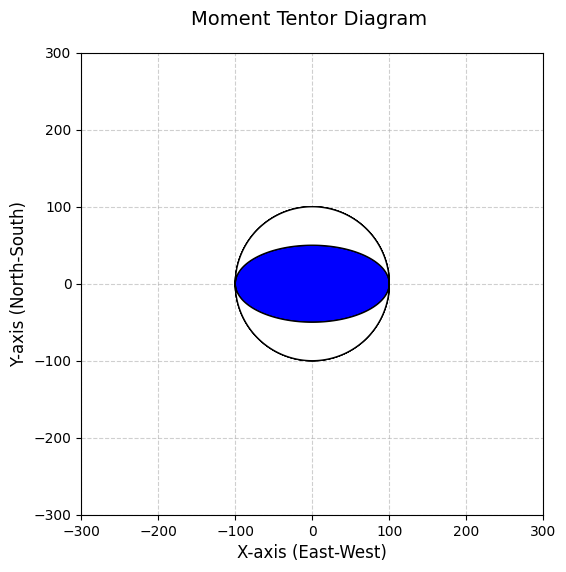

In [ ]:
import numpy as np
from obspy.core.event import MomentTensor, Tensor
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach

# Define the moment tensor components
Mxx, Myy, Mzz = 1e15, -1e15, 0  # Diagonal components
Mxy, Mxz, Myz = 0, 0, 0  # Off-diagonal components

# Construct the moment tensor
tensor = Tensor(m_rr=Mxx, m_tt=Myy, m_pp=Mzz, m_rt=Mxy, m_rp=Mxz, m_tp=Myz)
moment_tensor = MomentTensor(tensor=tensor)

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Define the moment tensor components in NED order for the beachball diagram
moment_tensor_components = [
    moment_tensor.tensor.m_rr,  # Mrr
    moment_tensor.tensor.m_tt,  # Mtt
    moment_tensor.tensor.m_pp,  # Mpp
    moment_tensor.tensor.m_rt,  # Mrt
    moment_tensor.tensor.m_rp,  # Mrp
    moment_tensor.tensor.m_tp,  # Mtp
]

# Add the beachball diagram
beachball_patch = beach(moment_tensor_components, xy=(0, 0), size=200, linewidth=1, facecolor='b')
ax.add_collection(beachball_patch)

# Set axis limits
ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)

# Add labels and title
ax.set_xlabel("X-axis (East-West)", fontsize=12)
ax.set_ylabel("Y-axis (North-South)", fontsize=12)
ax.set_title("Moment Tentor Diagram ", fontsize=14, pad=20)

# Add gridlines for reference
ax.grid(True, linestyle="--", alpha=0.6)

# Maintain equal aspect ratio
ax.set_aspect('equal', adjustable='box')

# Show the plot
plt.show()